In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.naive_bayes import MultinomialNB
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from itertools import product

In [2]:
df = pd.read_excel('dataset/Data 1.xlsx', names=['comment', 'polarity'])
df.shape

(152, 2)

In [3]:
df.head()

,comment,polarity
0,min bnyk yg kecewa lo dgn update terbaru alih ...,1
1,user id password mesti ke bank ya gpplah yg pe...,1
2,saat transfer kadang ada muncul keterangan kon...,1
3,begitu saya update dan no tlpn saya statusnya ...,1
4,tolong tambahkan fitur fingerprint atau face r...,1


## Preprocessing

<ol>
    <li>Case folding <b>(done at previous notebook)</b></li>
    <li>Cleansing <b>(done at previous notebook)</b></li>
    <li>Formalization</li>
    <li>Stemming</li>
    <li>Stopword Removal</li>
    <li>Tokenizing</li>
</ol>
    

### Formalization (Manual)

In [4]:
formal_dict = {}
with open('resources/formalization_dict.txt', 'r') as file:
    i = 1
    for row in file:
        old, new = row.split('\t')
        i += 1
        formal_dict[old] = new.lower().strip()

print(f'There are {len(formal_dict)} token pairs')

There are 51 token pairs


In [5]:
formal_comment = []

for comment in df.comment:
    sentence = ' '+comment+' '
    for false_word, true_word in formal_dict.items():
        word = ' '+false_word+' '
        sentence = sentence.replace(word, ' '+true_word+' ')
    formal_comment.append(sentence)
    
print(f'We have {len(formal_comment)} comments')

We have 152 comments


### Stemming (Sastrawi)

In [6]:
stemmer = StemmerFactory().create_stemmer()
comment_stemmed = [stemmer.stem(formal_comment[i]) for i in range(df.shape[0])]

comment_stemmed[0]

'min bnyk yang kecewa lo dengan update baru alih alih sempurna malah susah nasabah mandiri masuk saya agar kurang tindak tipu jahat waktu ada transaksi yang lebih rb rp maka bisa di tambah security upa kirim nomor verifikasi yang kirim ke nomor hp sms banking trus harus di masuk dalam applikasi mandiri online agar benar bahwa si nasabah sedang laku transaksi dengan demikian pasti tetap aman mohon perhati ya min terimakasih'

In [7]:
formal_comment[0]

' min bnyk yang kecewa lo dengan update terbaru alih alih penyempurnaan malah menyusahkan nasabah mandiri masukan saya agar mengurangi tindak penipuan kejahatan sewaktu ada transaksi yang lebih rb rp maka bisa di tambahkan security berupa pengiriman nomor verifikasi yang dikirimkan ke nomor hp sms banking trus harus di masukkan dalam applikasi mandiri online agar benar bahwa si nasabah sedang melakukan transaksi dengan demikian pasti tetap aman mohon diperhatikan ya min terimakasih '

### Stopwords Removal (Manual)

In [8]:
stopwords = [
    'yang', 'untuk', 'pada', 'antara', 'dan' , 'di', 'dari', 'hal', 
    'dalam', 'atau', 'kah', 'pun', 'dsb', 'dst', 'dll', 'toh', 'ya',
    'saya', 'dengan', 'nya', 'ke', 'si', 'dah'
]

print(f'There are {len(stopwords)} stopword list')

There are 23 stopword list


In [9]:
clean_comment = []
for comment in comment_stemmed:
    for token in stopwords:
        word = ' '+token+' '
        comment = comment.replace(word, ' ')
    if sentence.strip():
        clean_comment.append(comment.strip())
        
print(f'We have {len(clean_comment)} comments')

We have 152 comments


In [10]:
clean_comment[0]

'min bnyk kecewa lo update baru alih alih sempurna malah susah nasabah mandiri masuk agar kurang tindak tipu jahat waktu ada transaksi lebih rb rp maka bisa tambah security upa kirim nomor verifikasi kirim nomor hp sms banking trus harus masuk applikasi mandiri online agar benar bahwa nasabah sedang laku transaksi demikian pasti tetap aman mohon perhati min terimakasih'

### Tokenizing

In [84]:
features = np.array([np.array(comment.split()) for comment in clean_comment])
features[:2]

array([array(['min', 'bnyk', 'kecewa', 'lo', 'update', 'baru', 'alih', 'alih',
       'sempurna', 'malah', 'susah', 'nasabah', 'mandiri', 'masuk',
       'agar', 'kurang', 'tindak', 'tipu', 'jahat', 'waktu', 'ada',
       'transaksi', 'lebih', 'rb', 'rp', 'maka', 'bisa', 'tambah',
       'security', 'upa', 'kirim', 'nomor', 'verifikasi', 'kirim',
       'nomor', 'hp', 'sms', 'banking', 'trus', 'harus', 'masuk',
       'applikasi', 'mandiri', 'online', 'agar', 'benar', 'bahwa',
       'nasabah', 'sedang', 'laku', 'transaksi', 'demikian', 'pasti',
       'tetap', 'aman', 'mohon', 'perhati', 'min', 'terimakasih'],
      dtype='<U11'),
       array(['user', 'id', 'password', 'mesti', 'bank', 'gpplah', 'penting',
       'aman', 'transaksi'], dtype='<U9')], dtype=object)

## Split Dataset


> <b>Warning</b>: Don't run this code if you already have separated dataset before

In [69]:
df.polarity.value_counts()/df.shape[0]

0    0.552632
1    0.447368
Name: polarity, dtype: float64

In [86]:
labels = np.array(df.polarity)
len(labels)

152

In [72]:
kfold = KFold(n_splits=5, random_state=0)
for train, test in kfold.split(features, labels):
    print('Train', df.iloc[train, 1].value_counts() / len(train))
    print('Test', df.iloc[test, 1].value_counts() / len(test))
    print('===================')

Train 0    0.694215
1    0.305785
Name: polarity, dtype: float64
Test 1    1.0
Name: polarity, dtype: float64
Train 0    0.628099
1    0.371901
Name: polarity, dtype: float64
Test 1    0.741935
0    0.258065
Name: polarity, dtype: float64
Train 1    0.557377
0    0.442623
Name: polarity, dtype: float64
Test 0    1.0
Name: polarity, dtype: float64
Train 0    0.508197
1    0.491803
Name: polarity, dtype: float64
Test 0    0.733333
1    0.266667
Name: polarity, dtype: float64
Train 1    0.508197
0    0.491803
Name: polarity, dtype: float64
Test 0    0.8
1    0.2
Name: polarity, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [73]:
# split and save index of each batch train-test
skf = StratifiedKFold(n_splits=5, random_state=0)

i = 1
for train, test in skf.split(df.comment, df.polarity):
    np.save(f'dataset/train_{i}', train)
    np.save(f'dataset/test_{i}', test)
    print(f'train {i}\n', df.iloc[train, 1].value_counts()/len(train))
    print(f'test {i}\n', df.iloc[test, 1].value_counts()/len(test))
    print('===================')
    i += 1

train 1
 0    0.553719
1    0.446281
Name: polarity, dtype: float64
test 1
 0    0.548387
1    0.451613
Name: polarity, dtype: float64
train 2
 0    0.553719
1    0.446281
Name: polarity, dtype: float64
test 2
 0    0.548387
1    0.451613
Name: polarity, dtype: float64
train 3
 0    0.557377
1    0.442623
Name: polarity, dtype: float64
test 3
 0    0.533333
1    0.466667
Name: polarity, dtype: float64
train 4
 0    0.54918
1    0.45082
Name: polarity, dtype: float64
test 4
 0    0.566667
1    0.433333
Name: polarity, dtype: float64
train 5
 0    0.54918
1    0.45082
Name: polarity, dtype: float64
test 5
 0    0.566667
1    0.433333
Name: polarity, dtype: float64


## Modelling

### Multinomial Naive Bayes

In [33]:
NUM_BATCHES = 5
features = np.array(clean_comment)
labels = np.array(df.polarity)
smoothing_parameter = [1.0, .1, .01, .001]
train_eval, test_eval = [], []

for i in range(NUM_BATCHES):

    train_idx = np.load(f'dataset/train_{i+1}.npy')
    test_idx = np.load(f'dataset/test_{i+1}.npy')
    vectorizer = CountVectorizer()
    
    # 
    train_features = vectorizer.fit_transform(features[train_idx])
    test_features = vectorizer.transform(features[test_idx])
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]
    
    for param in smoothing_parameter:
        clf = MultinomialNB(alpha=param)
        clf.fit(train_features, train_labels)
        train_acc = clf.score(train_features, train_labels)
        test_acc = clf.score(test_features, test_labels)
        
        train_eval.append(train_acc)
        test_eval.append(test_acc)

print('Train and evaluate model completed')

Train and evaluate model completed


In [34]:
NUM_PARAMS = len(smoothing_parameter)
train_history = [[] for i in range(NUM_PARAMS)]
test_history = [[] for i in range(NUM_PARAMS)]

for i in range(len(train_eval)):
    idx = i % NUM_PARAMS
    train_history[idx].append(train_eval[i])
    test_history[idx].append(test_eval[i])

# append the average accuracy
for i in range(NUM_PARAMS):
    train_history[i].append(sum(train_history[i])/NUM_BATCHES)
    test_history[i].append(sum(test_history[i])/NUM_BATCHES)

if len(train_history[-1]) == NUM_BATCHES+1:
    print('Done')

Done


In [35]:
eval_history = {}
for i in range(NUM_PARAMS):
    eval_history[f'Train Acc (a={smoothing_parameter[i]})'] = train_history[i] 
    eval_history[f'Test Acc (a={smoothing_parameter[i]})'] = test_history[i]
    
history = pd.DataFrame(eval_history, index=['Batch-1', 'Batch-2', 'Batch-3', 
                                            'Batch-4', 'Batch-5', 'Average'])
history

,Train Acc (a=1.0),Test Acc (a=1.0),Train Acc (a=0.1),Test Acc (a=0.1),Train Acc (a=0.01),Test Acc (a=0.01),Train Acc (a=0.001),Test Acc (a=0.001)
Batch-1,0.975207,0.741935,1.000000,0.677419,1.000000,0.709677,1.000000,0.677419
Batch-2,0.950413,0.903226,0.975207,0.774194,0.975207,0.612903,0.975207,0.612903
Batch-3,0.975410,0.800000,0.975410,0.766667,0.983607,0.733333,0.983607,0.700000
Batch-4,0.967213,0.766667,0.983607,0.833333,0.991803,0.833333,0.991803,0.800000
Batch-5,0.975410,0.400000,0.991803,0.333333,0.991803,0.300000,0.991803,0.300000
Average,0.968731,0.722366,0.985205,0.676989,0.988484,0.637849,0.988484,0.618065


the lower the alpha value, the lower the accuracy value on the test data (Overfitting)

We got <b>the best result</b> from Multinomial Naive Bayes Model with <b>alpha = 1.0</b> that is: <h3>72.24%</h3>

### Multinomial Naive Bayes + TF-IDF

<h3>Important</h3>
<ol>
    <li>ngram_range</li>
    <li>max_df: occurred in too many documents(common word)</li>
    <li>min_df: occurred in too few documents (typo, alay)</li>
</ol>

In [36]:
ngram = [(1, 1), (1, 2), (1, 3)]
min_df = [0.0, .1, .2, .3]
max_df = [.4, .5, .6, .7 , .8, .9, 1.0]

param_combinations = list(product(ngram, min_df, max_df))
param_combinations[:3]

[((1, 1), 0.0, 0.4), ((1, 1), 0.0, 0.5), ((1, 1), 0.0, 0.6)]

In [37]:
NUM_BATCHES = 5
features = np.array(clean_comment)
labels = np.array(df.polarity)
train_eval, test_eval = [], []

for i in range(NUM_BATCHES):

    train_idx = np.load(f'dataset/train_{i+1}.npy')
    test_idx = np.load(f'dataset/test_{i+1}.npy')
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]
    
    for param in param_combinations:
        tfidf_vectorizer = TfidfVectorizer(ngram_range=param[0], min_df=param[1], max_df=param[2])
        train_features = tfidf_vectorizer.fit_transform(features[train_idx])
        test_features = tfidf_vectorizer.transform(features[test_idx])
        
        # train and evaluate
        clf = MultinomialNB()
        clf.fit(train_features, train_labels)
        train_acc = clf.score(train_features, train_labels)
        test_acc = clf.score(test_features, test_labels)
        
        train_eval.append(train_acc)
        test_eval.append(test_acc)
        
print('Train and evaluate model completed')

Train and evaluate model completed


In [38]:
NUM_PARAMS = len(param_combinations)
train_history = [[] for i in range(NUM_PARAMS)]
test_history = [[] for i in range(NUM_PARAMS)]

for i in range(len(train_eval)):
    idx = i % NUM_PARAMS
    train_history[idx].append(train_eval[i])
    test_history[idx].append(test_eval[i])

# append the average accuracy
for i in range(NUM_PARAMS):
    train_history[i].append(sum(train_history[i])/NUM_BATCHES)
    test_history[i].append(sum(test_history[i])/NUM_BATCHES)

if len(train_history[-1]) == NUM_BATCHES+1:
    print('Done')

Done


In [39]:
eval_history = {}
for i in range(NUM_PARAMS):
    eval_history[f'Train Acc (ngram={param_combinations[i][0]}), min_df={param_combinations[i][1]}, max_df={param_combinations[i][2]}'] = train_history[i] 
    eval_history[f'Test Acc (ngram={param_combinations[i][0]}), min_df={param_combinations[i][1]}, max_df={param_combinations[i][2]}'] = test_history[i]
    
history_tfidf = pd.DataFrame(eval_history, index=['Batch-1', 'Batch-2', 'Batch-3', 
                                                  'Batch-4', 'Batch-5', 'Average'])
history_tfidf

,"Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.4","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.4","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.6","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.6","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.8","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.8",...,"Train Acc (ngram=(1, 3)), min_df=0.3, max_df=0.6","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=0.6","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=0.7","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=0.7","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=0.8","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=0.8","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=0.9","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=0.9","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0"
Batch-1,0.991736,0.709677,0.991736,0.709677,0.991736,0.709677,0.991736,0.709677,0.991736,0.709677,...,0.834711,0.935484,0.834711,0.935484,0.834711,0.935484,0.834711,0.935484,0.834711,0.935484
Batch-2,0.975207,0.774194,0.975207,0.774194,0.975207,0.774194,0.975207,0.774194,0.975207,0.774194,...,0.826446,0.935484,0.826446,0.935484,0.826446,0.935484,0.826446,0.935484,0.826446,0.935484
Batch-3,0.975410,0.700000,0.975410,0.700000,0.975410,0.700000,0.975410,0.700000,0.975410,0.700000,...,0.860656,0.933333,0.860656,0.933333,0.860656,0.933333,0.860656,0.933333,0.860656,0.933333
Batch-4,0.975410,0.800000,0.975410,0.733333,0.975410,0.733333,0.975410,0.733333,0.975410,0.733333,...,0.868852,0.900000,0.868852,0.900000,0.868852,0.900000,0.868852,0.900000,0.868852,0.900000
Batch-5,0.959016,0.466667,0.959016,0.533333,0.959016,0.533333,0.959016,0.533333,0.959016,0.533333,...,0.868852,0.600000,0.868852,0.600000,0.868852,0.600000,0.868852,0.600000,0.868852,0.600000
Average,0.975356,0.690108,0.975356,0.690108,0.975356,0.690108,0.975356,0.690108,0.975356,0.690108,...,0.851904,0.860860,0.851904,0.860860,0.851904,0.860860,0.851904,0.860860,0.851904,0.860860


In [40]:
test_col = [col for col in history_tfidf.columns if col.startswith('Test')]
test_col[history_tfidf.loc['Average', test_col].argmax()]

'Test Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5'

In [41]:
history_tfidf[['Train Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5', 'Test Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5']]

,"Train Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5","Test Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5"
Batch-1,0.834711,0.935484
Batch-2,0.826446,0.935484
Batch-3,0.860656,0.933333
Batch-4,0.868852,0.900000
Batch-5,0.868852,0.600000
Average,0.851904,0.860860



We got <b>the best result</b> from Multinomial Naive Bayes Model with 
<b>minimum</b> of word's occurrences is <b>30%</b> of total documents, 
<b>maximum</b> of word's occurrences is <b>50%</b> of total documents, 
and <b>only use 1 gram</b> that is: <h3>86.01%</h3>

### Multinomial Naive Bayes +  Information Gain

In [241]:
train_idx = np.load(f'dataset/train_1.npy')
test_idx = np.load(f'dataset/test_1.npy')
train_labels = labels[train_idx]
test_labels = labels[test_idx]

vectorizer = CountVectorizer()
train_count_features = vectorizer.fit_transform(features[train_idx])
test_count_features = vectorizer.transform(features[test_idx])

ig_res = dict(zip(vectorizer.get_feature_names(),
                  mutual_info_classif(train_count_features, train_labels, discrete_features=True)
               ))
ig_res = sorted(ig_res.items(), key=lambda x: x[1], reverse=True)
ig_res[:5]

[('aman', 0.4302862055362001),
 ('tidak', 0.3201787480418658),
 ('bisa', 0.3150763461017261),
 ('ini', 0.24675401200991912),
 ('aplikasi', 0.20636826950745146)]

In [42]:
def remove_token(bad_token, dataset):
    clean_dataset = []
    for comment in dataset:
        comment = ' '+comment+' '
        for token in bad_token:
            word = ' '+token+' '
            comment = comment.replace(word, ' ')
        
        clean_dataset.append(comment.strip())
        
    return np.array(clean_dataset)


In [43]:
NUM_BATCHES = 5
ig_tresh = [1e-1, 1e-2, 1e-3]
features = np.array(clean_comment)
labels = np.array(df.polarity)
train_eval, test_eval = [], []

for i in range(NUM_BATCHES):

    train_idx = np.load(f'dataset/train_{i+1}.npy')
    test_idx = np.load(f'dataset/test_{i+1}.npy')
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]
    
    vectorizer = CountVectorizer()
    train_count_features = vectorizer.fit_transform(features[train_idx])
    test_count_features = vectorizer.transform(features[test_idx])

    ig_res = dict(zip(vectorizer.get_feature_names(),
                      mutual_info_classif(train_count_features, train_labels, discrete_features=True)
                   ))
    ig_res = sorted(ig_res.items(), key=lambda x: x[1], reverse=True)

    below_tresh = []
    for j in range(len(ig_tresh)):
        below_tresh.append([ig[0] for ig in ig_res if ig[1] < ig_tresh[j]])
    
        new_features = remove_token(below_tresh[j], features)

        count_vectorizer = CountVectorizer()
        train_features = count_vectorizer.fit_transform(new_features[train_idx])
        test_features = count_vectorizer.transform(new_features[test_idx])

        # train and evaluate
        clf = MultinomialNB()
        clf.fit(train_features, train_labels)
        train_acc = clf.score(train_features, train_labels)
        test_acc = clf.score(test_features, test_labels)

        train_eval.append(train_acc)
        test_eval.append(test_acc)

print('Train and evaluate model completed')

Train and evaluate model completed


In [44]:
NUM_PARAMS = len(ig_tresh)
train_history = [[] for i in range(NUM_PARAMS)]
test_history = [[] for i in range(NUM_PARAMS)]

for i in range(len(train_eval)):
    idx = i % NUM_PARAMS
    train_history[idx].append(train_eval[i])
    test_history[idx].append(test_eval[i])

# append the average accuracy
for i in range(NUM_PARAMS):
    train_history[i].append(sum(train_history[i])/NUM_BATCHES)
    test_history[i].append(sum(test_history[i])/NUM_BATCHES)

if len(train_history[-1]) == NUM_BATCHES+1:
    print('Done')

Done


In [45]:
eval_history = {}
for i in range(NUM_PARAMS):
    eval_history[f'Train Acc (tresh={ig_tresh[i]})'] = train_history[i] 
    eval_history[f'Test Acc (tresh={ig_tresh[i]})'] = test_history[i]
    
history_ig = pd.DataFrame(eval_history, index=['Batch-1', 'Batch-2', 'Batch-3', 
                                                  'Batch-4', 'Batch-5', 'Average'])
history_ig

,Train Acc (tresh=0.1),Test Acc (tresh=0.1),Train Acc (tresh=0.01),Test Acc (tresh=0.01),Train Acc (tresh=0.001),Test Acc (tresh=0.001)
Batch-1,0.892562,1.000000,0.950413,0.741935,0.983471,0.774194
Batch-2,0.900826,1.000000,0.942149,0.903226,0.958678,0.903226
Batch-3,0.909836,0.933333,0.975410,0.766667,0.967213,0.800000
Batch-4,0.926230,0.900000,0.942623,0.733333,0.967213,0.766667
Batch-5,0.967213,0.633333,0.959016,0.533333,0.975410,0.433333
Average,0.919333,0.893333,0.953922,0.735699,0.970397,0.735484


If we compare with model that <b>not using information gain</b>, we get <b>89.33%</b> for test accuracy.
And with <b>using information gain treshold = 0.1</b> as the best parameter we get:
<h3>89.33%</h3>


### Multinomial Naive Bayes +  Information Gain + TF-IDF

In [15]:
ngram = [(1, 1), (1, 2), (1, 3)]
min_df = [0.0, .1, .2, .3]
max_df = [.5, .6, .7 , .8, .9, 1.0]
ig_tresh = [1e-2, 1e-3, 1e-4, 1e-100]

param_combinations = list(product(ngram, min_df, max_df, ig_tresh))
param_combinations[:3]

[((1, 1), 0.0, 0.5, 0.01),
 ((1, 1), 0.0, 0.5, 0.001),
 ((1, 1), 0.0, 0.5, 0.0001)]

In [16]:
NUM_BATCHES = 5
features = np.array(clean_comment)
labels = np.array(df.polarity)
train_eval, test_eval = [], []

for i in range(NUM_BATCHES):

    train_idx = np.load(f'dataset/train_{i+1}.npy')
    test_idx = np.load(f'dataset/test_{i+1}.npy')
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]
    
    vectorizer = CountVectorizer()
    train_count_features = vectorizer.fit_transform(features[train_idx])
    test_count_features = vectorizer.transform(features[test_idx])

    ig_res = dict(zip(vectorizer.get_feature_names(),
                      mutual_info_classif(train_count_features, train_labels, discrete_features=True)
                   ))
    ig_res = sorted(ig_res.items(), key=lambda x: x[1], reverse=True)
    
    for param in param_combinations:
        below_tresh = [ig[0] for ig in ig_res if ig[1] < param[-1]]
        new_features = remove_token(below_tresh, features)
        
        tfidf_vectorizer = TfidfVectorizer(ngram_range=param[0], min_df=param[1], max_df=param[2])
        train_features = tfidf_vectorizer.fit_transform(new_features[train_idx])
        test_features = tfidf_vectorizer.transform(new_features[test_idx])

        # train and evaluate
        clf = MultinomialNB()
        clf.fit(train_features, train_labels)
        train_acc = clf.score(train_features, train_labels)
        test_acc = clf.score(test_features, test_labels)
        
        train_eval.append(train_acc)
        test_eval.append(test_acc)

print('Train and evaluate model completed')

Train and evaluate model completed


In [17]:
NUM_PARAMS = len(param_combinations)
train_history = [[] for i in range(NUM_PARAMS)]
test_history = [[] for i in range(NUM_PARAMS)]

for i in range(len(train_eval)):
    idx = i % NUM_PARAMS
    train_history[idx].append(train_eval[i])
    test_history[idx].append(test_eval[i])

# append the average accuracy
for i in range(NUM_PARAMS):
    train_history[i].append(sum(train_history[i])/NUM_BATCHES)
    test_history[i].append(sum(test_history[i])/NUM_BATCHES)

if len(train_history[-1]) == NUM_BATCHES+1:
    print('Done')

Done


In [18]:
eval_history = {}
for i in range(NUM_PARAMS):
    eval_history[f'Train Acc (ngram={param_combinations[i][0]}), min_df={param_combinations[i][1]}, max_df={param_combinations[i][2]}, tresh={param_combinations[i][-1]}'] = train_history[i] 
    eval_history[f'Test Acc (ngram={param_combinations[i][0]}), min_df={param_combinations[i][1]}, max_df={param_combinations[i][2]}, tresh={param_combinations[i][-1]}'] = test_history[i]
    , tresh={}
history_ig_tfidf = pd.DataFrame(eval_history, index=['Batch-1', 'Batch-2', 'Batch-3', 
                                                  'Batch-4', 'Batch-5', 'Average'])
history_ig_tfidf

,"Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, tresh=0.01","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, tresh=0.01","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, tresh=0.001","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, tresh=0.001","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, tresh=0.0001","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, tresh=0.0001","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, tresh=1e-100","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.5, tresh=1e-100","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.6, tresh=0.01","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.6, tresh=0.01",...,"Train Acc (ngram=(1, 3)), min_df=0.3, max_df=0.9, tresh=1e-100","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=0.9, tresh=1e-100","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, tresh=0.01","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, tresh=0.01","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, tresh=0.001","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, tresh=0.001","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, tresh=0.0001","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, tresh=0.0001","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, tresh=1e-100","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, tresh=1e-100"
Batch-1,0.950413,0.677419,1.000000,0.677419,1.000000,0.709677,0.991736,0.709677,0.950413,0.677419,...,0.834711,0.935484,0.834711,0.935484,0.834711,0.935484,0.834711,0.935484,0.834711,0.935484
Batch-2,0.942149,0.870968,0.975207,0.806452,0.975207,0.774194,0.975207,0.774194,0.942149,0.870968,...,0.826446,0.935484,0.826446,0.935484,0.826446,0.935484,0.826446,0.935484,0.826446,0.935484
Batch-3,0.967213,0.766667,0.975410,0.733333,0.975410,0.700000,0.975410,0.700000,0.967213,0.766667,...,0.860656,0.933333,0.860656,0.933333,0.860656,0.933333,0.860656,0.933333,0.860656,0.933333
Batch-4,0.934426,0.733333,0.983607,0.733333,0.975410,0.766667,0.975410,0.733333,0.934426,0.733333,...,0.868852,0.900000,0.868852,0.900000,0.868852,0.900000,0.868852,0.900000,0.868852,0.900000
Batch-5,0.975410,0.466667,0.967213,0.533333,0.959016,0.466667,0.959016,0.533333,0.975410,0.466667,...,0.868852,0.600000,0.868852,0.600000,0.868852,0.600000,0.868852,0.600000,0.868852,0.600000
Average,0.953922,0.703011,0.980287,0.696774,0.977009,0.683441,0.975356,0.690108,0.953922,0.703011,...,0.851904,0.860860,0.851904,0.860860,0.851904,0.860860,0.851904,0.860860,0.851904,0.860860


In [19]:
test_col = [col for col in history_ig_tfidf.columns if col.startswith('Test')]
test_col[history_ig_tfidf.loc['Average', test_col].argmax()]


'Test Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5, tresh=0.01'

In [31]:
history_ig_tfidf[['Train Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5, tresh=0.01', 'Test Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5, tresh=0.01']]

,"Train Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5, tresh=0.01","Test Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5, tresh=0.01"
Batch-1,0.834711,0.935484
Batch-2,0.826446,0.935484
Batch-3,0.860656,0.933333
Batch-4,0.868852,0.900000
Batch-5,0.868852,0.600000
Average,0.851904,0.860860


In [32]:
history_ig_tfidf[['Train Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5, tresh=1e-100', 'Test Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5, tresh=1e-100']]

,"Train Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5, tresh=1e-100","Test Acc (ngram=(1, 1)), min_df=0.3, max_df=0.5, tresh=1e-100"
Batch-1,0.834711,0.935484
Batch-2,0.826446,0.935484
Batch-3,0.860656,0.933333
Batch-4,0.868852,0.900000
Batch-5,0.868852,0.600000
Average,0.851904,0.860860


We get same score for using and without using information gain that is:
<h3>86.01%</h3>


### Multinomial Naive Bayes +  Chi Square

In [115]:
def remove_token(bad_token, dataset):
    clean_dataset = []
    for comment in dataset:
        comment = ' '+comment+' '
        for token in bad_token:
            word = ' '+token+' '
            comment = comment.replace(word, ' ')
        
        clean_dataset.append(comment.strip())
    
    assert len(dataset) == len(clean_dataset)
    
    return np.array(clean_dataset)


def calculate_qer_score(features, labels):
    """
    When a feature has low score, the diference between the probabilities 
    for the positive and negative classes is high; therefore the feature is 
    more class specifc and more valuable for classifcation process.
    
    score(f) = p(f) + q(f)/ |p(f) - q(f)|
    p(f) = df(+) + .5/ n(+) + 1.0
    q(f) = df(-) +.5/ n(-) + .5
    df(+) --> document of f with positive class
    n(+) ---> total document with positive class
    """

    # create a dataset
    dataset = [*zip(features, labels)]

    # count frequency each class labels
    label_counts = Counter(train_labels)

    # extract all features
    count_vectorizer = CountVectorizer()
    count_vectorizer.fit_transform(features)
    feature_names = count_vectorizer.get_feature_names()

    qer_score = {}
    for word in feature_names:
        doc_freq = {}

        # count frequency each word at certain class labels
        word = ' '+word+' '

        for label in label_counts:
            doc_freq[label] = 0

        for doc in dataset:
            sentence = ' '+doc[0]+' '
            if word in sentence:
                doc_freq[doc[1]] += 1

        pf = (doc_freq[1] + .5) / (label_counts[1] + 1.0)
        qf = (doc_freq[0] + .5) / (label_counts[0] + .5)
        score = (pf + qf) / abs(pf - qf)
        qer_score[word.strip()] = score
        
    return qer_score

In [46]:
confidence_interval_list = [0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95]
NUM_BATCHES = 5
features = np.array(clean_comment)
labels = np.array(df.polarity)
train_eval, test_eval = [], []

for i in range(NUM_BATCHES):

    train_idx = np.load(f'dataset/train_{i+1}.npy')
    test_idx = np.load(f'dataset/test_{i+1}.npy')
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]
    
    vectorizer = CountVectorizer()
    train_count_features = vectorizer.fit_transform(features[train_idx])
    test_count_features = vectorizer.transform(features[test_idx])

    chi2_val, p_val = chi2(train_count_features, train_labels)
    chi2_res = list(zip(vectorizer.get_feature_names(), chi2_val, p_val))
    
    for confidence_interval in confidence_interval_list:
        # if p-value > alpha, then accept H0 (independent)
        alpha = 1.0 - confidence_interval
        below_tresh = [word[0] for word in chi2_res if word[2] > alpha]
        new_features = remove_token(below_tresh, features)
        
        count_vectorizer = CountVectorizer()
        train_features = count_vectorizer.fit_transform(new_features[train_idx])
        test_features = count_vectorizer.transform(new_features[test_idx])
        
        # train and evaluate
        clf = MultinomialNB()
        clf.fit(train_features, train_labels)
        train_acc = clf.score(train_features, train_labels)
        test_acc = clf.score(test_features, test_labels)

        train_eval.append(train_acc)
        test_eval.append(test_acc)

print('Train and evaluate model completed')

Train and evaluate model completed


In [47]:
NUM_PARAMS = len(confidence_interval_list)
train_history = [[] for i in range(NUM_PARAMS)]
test_history = [[] for i in range(NUM_PARAMS)]

for i in range(len(train_eval)):
    idx = i % NUM_PARAMS
    train_history[idx].append(train_eval[i])
    test_history[idx].append(test_eval[i])

# append the average accuracy
for i in range(NUM_PARAMS):
    train_history[i].append(sum(train_history[i])/NUM_BATCHES)
    test_history[i].append(sum(test_history[i])/NUM_BATCHES)

if len(train_history[-1]) == NUM_BATCHES+1:
    print('Done')

Done


In [48]:
eval_history = {}
for i in range(NUM_PARAMS):
    eval_history[f'Train Acc (confidence interval={confidence_interval_list[i]})'] = train_history[i] 
    eval_history[f'Test Acc (confidence interval={confidence_interval_list[i]})'] = test_history[i]
    , tresh={}
history_chi2 = pd.DataFrame(eval_history, index=['Batch-1', 'Batch-2', 'Batch-3', 
                                                  'Batch-4', 'Batch-5', 'Average'])
history_chi2

,Train Acc (confidence interval=0.0),Test Acc (confidence interval=0.0),Train Acc (confidence interval=0.1),Test Acc (confidence interval=0.1),Train Acc (confidence interval=0.2),Test Acc (confidence interval=0.2),Train Acc (confidence interval=0.3),Test Acc (confidence interval=0.3),Train Acc (confidence interval=0.4),Test Acc (confidence interval=0.4),...,Train Acc (confidence interval=0.6),Test Acc (confidence interval=0.6),Train Acc (confidence interval=0.7),Test Acc (confidence interval=0.7),Train Acc (confidence interval=0.8),Test Acc (confidence interval=0.8),Train Acc (confidence interval=0.9),Test Acc (confidence interval=0.9),Train Acc (confidence interval=0.95),Test Acc (confidence interval=0.95)
Batch-1,0.975207,0.741935,0.975207,0.741935,0.975207,0.741935,0.983471,0.741935,0.975207,0.741935,...,0.975207,0.709677,0.958678,0.741935,0.958678,0.806452,0.933884,0.741935,0.933884,0.806452
Batch-2,0.950413,0.903226,0.950413,0.903226,0.958678,0.903226,0.958678,0.903226,0.958678,0.903226,...,0.966942,0.903226,0.950413,0.870968,0.933884,0.870968,0.950413,0.903226,0.942149,0.967742
Batch-3,0.975410,0.800000,0.975410,0.800000,0.967213,0.800000,0.967213,0.800000,0.967213,0.800000,...,0.967213,0.766667,0.967213,0.800000,0.967213,0.766667,0.959016,0.800000,0.959016,0.800000
Batch-4,0.967213,0.766667,0.967213,0.766667,0.967213,0.733333,0.967213,0.733333,0.967213,0.766667,...,0.967213,0.766667,0.967213,0.833333,0.950820,0.733333,0.942623,0.766667,0.926230,0.833333
Batch-5,0.975410,0.400000,0.975410,0.400000,0.975410,0.433333,0.975410,0.433333,0.975410,0.466667,...,0.983607,0.500000,0.983607,0.500000,0.967213,0.433333,0.950820,0.533333,0.950820,0.500000
Average,0.968731,0.722366,0.968731,0.722366,0.968744,0.722366,0.970397,0.722366,0.968744,0.735699,...,0.972036,0.729247,0.965425,0.749247,0.955562,0.722151,0.947351,0.749032,0.942420,0.781505


In [49]:
test_col = [col for col in history_chi2.columns if col.startswith('Test')]
test_col[history_chi2.loc['Average', test_col].argmax()]


'Test Acc (confidence interval=0.95)'

(0.5, 1.0)

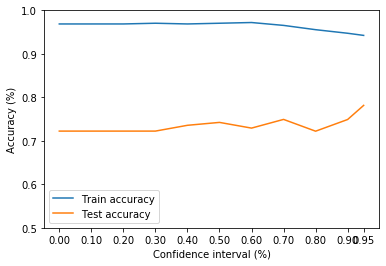

In [50]:
train_col = [col for col in history_chi2.columns if col.startswith('Train')]
plt.plot(confidence_interval_list, history_chi2.loc['Average', train_col], label='Train accuracy')
plt.plot(confidence_interval_list, history_chi2.loc['Average', test_col], label='Test accuracy')
plt.legend()
plt.xlabel('Confidence interval (%)')
plt.xticks(confidence_interval_list)
plt.ylabel('Accuracy (%)')
plt.ylim([.5, 1.0])

In [51]:
history_chi2[['Train Acc (confidence interval=0.95)', 'Test Acc (confidence interval=0.95)']]

,Train Acc (confidence interval=0.95),Test Acc (confidence interval=0.95)
Batch-1,0.933884,0.806452
Batch-2,0.942149,0.967742
Batch-3,0.959016,0.800000
Batch-4,0.926230,0.833333
Batch-5,0.950820,0.500000
Average,0.942420,0.781505


Refer from above result we can get the best result with <b>confidence interval 95%</b>, that is:

<h3>78.15%</h3>

### Multinomial Naive Bayes +  Chi Square + TF-IDF

In [52]:
ngram = [(1, 1), (1, 2), (1, 3)]
min_df = [0.0, .1, .2, .3]
max_df = [.7 , .8, .9, 1.0]
confidence_interval_list = [0.0, .6, .7, .8, .9, .95]

param_combinations = list(product(ngram, min_df, max_df, confidence_interval_list))
param_combinations[:3]

[((1, 1), 0.0, 0.7, 0.0), ((1, 1), 0.0, 0.7, 0.6), ((1, 1), 0.0, 0.7, 0.7)]

In [53]:
NUM_BATCHES = 5
features = np.array(clean_comment)
labels = np.array(df.polarity)
train_eval, test_eval = [], []

for i in range(NUM_BATCHES):

    train_idx = np.load(f'dataset/train_{i+1}.npy')
    test_idx = np.load(f'dataset/test_{i+1}.npy')
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]
    
    vectorizer = CountVectorizer()
    train_count_features = vectorizer.fit_transform(features[train_idx])
    test_count_features = vectorizer.transform(features[test_idx])

    chi2_val, p_val = chi2(train_count_features, train_labels)
    chi2_res = list(zip(vectorizer.get_feature_names(), chi2_val, p_val))
    
    for param in param_combinations:
        # if p-value > alpha, then accept H0 (independent)
        alpha = 1.0 - param[-1]
        below_tresh = [word[0] for word in chi2_res if word[2] > alpha]
        new_features = remove_token(below_tresh, features)
        
        tfidf_vectorizer = TfidfVectorizer(ngram_range=param[0], min_df=param[1], max_df=param[2])
        train_features = tfidf_vectorizer.fit_transform(new_features[train_idx])
        test_features = tfidf_vectorizer.transform(new_features[test_idx])

        # train and evaluate
        clf = MultinomialNB()
        clf.fit(train_features, train_labels)
        train_acc = clf.score(train_features, train_labels)
        test_acc = clf.score(test_features, test_labels)
        
        train_eval.append(train_acc)
        test_eval.append(test_acc)

print('Train and evaluate model completed')

Train and evaluate model completed


In [55]:
NUM_PARAMS = len(param_combinations)
train_history = [[] for i in range(NUM_PARAMS)]
test_history = [[] for i in range(NUM_PARAMS)]

for i in range(len(train_eval)):
    idx = i % NUM_PARAMS
    train_history[idx].append(train_eval[i])
    test_history[idx].append(test_eval[i])

# append the average accuracy
for i in range(NUM_PARAMS):
    train_history[i].append(sum(train_history[i])/NUM_BATCHES)
    test_history[i].append(sum(test_history[i])/NUM_BATCHES)

if len(train_history[-1]) == NUM_BATCHES+1:
    print('Done')

Done


In [56]:
eval_history = {}
for i in range(NUM_PARAMS):
    eval_history[f'Train Acc (ngram={param_combinations[i][0]}), min_df={param_combinations[i][1]}, max_df={param_combinations[i][2]}, confidence interval={param_combinations[i][-1]})'] = train_history[i] 
    eval_history[f'Test Acc (ngram={param_combinations[i][0]}), min_df={param_combinations[i][1]}, max_df={param_combinations[i][2]}, confidence interval={param_combinations[i][-1]})'] = test_history[i]
    , tresh={}
history_chi2_tfidf = pd.DataFrame(eval_history, index=['Batch-1', 'Batch-2', 'Batch-3', 
                                                  'Batch-4', 'Batch-5', 'Average'])
history_chi2_tfidf

,"Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, confidence interval=0.0)","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, confidence interval=0.0)","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, confidence interval=0.6)","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, confidence interval=0.6)","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, confidence interval=0.7)","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, confidence interval=0.7)","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, confidence interval=0.8)","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, confidence interval=0.8)","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, confidence interval=0.9)","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, confidence interval=0.9)",...,"Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, confidence interval=0.6)","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, confidence interval=0.6)","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, confidence interval=0.7)","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, confidence interval=0.7)","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, confidence interval=0.8)","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, confidence interval=0.8)","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, confidence interval=0.9)","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, confidence interval=0.9)","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, confidence interval=0.95)","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, confidence interval=0.95)"
Batch-1,0.991736,0.709677,0.991736,0.741935,0.983471,0.677419,0.975207,0.677419,0.958678,0.741935,...,0.818182,0.935484,0.818182,0.935484,0.818182,0.935484,0.818182,0.935484,0.793388,0.903226
Batch-2,0.975207,0.774194,0.958678,0.870968,0.958678,0.806452,0.942149,0.838710,0.942149,0.838710,...,0.826446,0.903226,0.826446,0.903226,0.826446,0.903226,0.826446,0.903226,0.801653,0.870968
Batch-3,0.975410,0.700000,0.975410,0.766667,0.967213,0.766667,0.975410,0.766667,0.959016,0.800000,...,0.860656,0.933333,0.860656,0.933333,0.860656,0.933333,0.877049,0.933333,0.877049,0.933333
Batch-4,0.975410,0.733333,0.975410,0.733333,0.950820,0.800000,0.959016,0.733333,0.950820,0.733333,...,0.868852,0.933333,0.868852,0.933333,0.868852,0.933333,0.868852,0.933333,0.549180,0.566667
Batch-5,0.959016,0.533333,0.975410,0.566667,0.967213,0.566667,0.975410,0.466667,0.967213,0.600000,...,0.868852,0.600000,0.934426,0.600000,0.934426,0.600000,0.934426,0.600000,0.549180,0.566667
Average,0.975356,0.690108,0.975329,0.735914,0.965479,0.723441,0.965438,0.696559,0.955575,0.742796,...,0.848598,0.861075,0.861713,0.861075,0.861713,0.861075,0.864991,0.861075,0.714090,0.768172


In [57]:
test_col = [col for col in history_chi2_tfidf.columns if col.startswith('Test')]
test_col[history_chi2_tfidf.loc['Average', test_col].argmax()]

'Test Acc (ngram=(1, 1)), min_df=0.2, max_df=0.7, confidence interval=0.95)'

In [58]:
history_chi2_tfidf[['Train Acc (ngram=(1, 1)), min_df=0.2, max_df=0.7, confidence interval=0.95)', 'Test Acc (ngram=(1, 1)), min_df=0.2, max_df=0.7, confidence interval=0.95)']]

,"Train Acc (ngram=(1, 1)), min_df=0.2, max_df=0.7, confidence interval=0.95)","Test Acc (ngram=(1, 1)), min_df=0.2, max_df=0.7, confidence interval=0.95)"
Batch-1,0.859504,0.935484
Batch-2,0.826446,0.967742
Batch-3,0.885246,0.900000
Batch-4,0.877049,0.933333
Batch-5,0.950820,0.633333
Average,0.879813,0.873978


We got <b>the best result</b> from Multinomial Naive Bayes Model with 
<b>chi-square</b> as feature selection with <b>confidence interval = 95%</b>,
and another parameter from TF-IDF such as <b>minimum</b> of word's occurrences is <b>20%</b> of total documents, 
<b>maximum</b> of word's occurrences is <b>70%</b> of total documents, 
<b>only use 1 gram</b> that is: <h3>87.40%</h3>

### Multinomial Naive Bayes +  Query Expansion Ranking

In [172]:
NUM_BATCHES = 5
features = np.array(clean_comment)
labels = np.array(df.polarity)
train_eval, test_eval = [], []
keep_data = [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95, 1.]

for i in range(NUM_BATCHES):

    train_idx = np.load(f'dataset/train_{i+1}.npy')
    test_idx = np.load(f'dataset/test_{i+1}.npy')
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]
    train_features = features[train_idx]

    # calculate qer score
    qer_score = calculate_qer_score(train_features, train_labels)
    size_train_features = len(qer_score)
    sorted_qer_score = sorted(qer_score.items(), key=lambda x: x[1])
    
    for percent in keep_data:
        # create new features with selected good feature with qer score
        boundary_idx = round(size_train_features * percent)
        below_tresh = [word[0] for word in sorted_qer_score[boundary_idx:]]
        new_features = remove_token(below_tresh, features)
        
        vectorizer = CountVectorizer()
        new_train_features = vectorizer.fit_transform(new_features[train_idx])
        new_test_features = vectorizer.transform(new_features[test_idx])
        
        # train and evaluate
        clf = MultinomialNB()
        clf.fit(new_train_features, train_labels)
        train_acc = clf.score(new_train_features, train_labels)
        test_acc = clf.score(new_test_features, test_labels)

        train_eval.append(train_acc)
        test_eval.append(test_acc)

print('Train and evaluate model completed')

Train and evaluate model completed


In [173]:
NUM_PARAMS = len(keep_data)
train_history = [[] for i in range(NUM_PARAMS)]
test_history = [[] for i in range(NUM_PARAMS)]

for i in range(len(train_eval)):
    idx = i % NUM_PARAMS
    train_history[idx].append(train_eval[i])
    test_history[idx].append(test_eval[i])

# append the average accuracy
for i in range(NUM_PARAMS):
    train_history[i].append(sum(train_history[i])/NUM_BATCHES)
    test_history[i].append(sum(test_history[i])/NUM_BATCHES)

if len(train_history[-1]) == NUM_BATCHES+1:
    print('Done')

Done


In [174]:
eval_history = {}
for i in range(NUM_PARAMS):
    eval_history[f'Train Acc (keep data={round(keep_data[i]*100, 2)}%)'] = train_history[i] 
    eval_history[f'Test Acc (keep data={round(keep_data[i]*100, 2)}%)'] = test_history[i]
    , tresh={}
history_qer = pd.DataFrame(eval_history, index=['Batch-1', 'Batch-2', 'Batch-3', 
                                                  'Batch-4', 'Batch-5', 'Average'])
history_qer

,Train Acc (keep data=10.0%),Test Acc (keep data=10.0%),Train Acc (keep data=20.0%),Test Acc (keep data=20.0%),Train Acc (keep data=30.0%),Test Acc (keep data=30.0%),Train Acc (keep data=40.0%),Test Acc (keep data=40.0%),Train Acc (keep data=50.0%),Test Acc (keep data=50.0%),...,Train Acc (keep data=70.0%),Test Acc (keep data=70.0%),Train Acc (keep data=80.0%),Test Acc (keep data=80.0%),Train Acc (keep data=90.0%),Test Acc (keep data=90.0%),Train Acc (keep data=95.0%),Test Acc (keep data=95.0%),Train Acc (keep data=100.0%),Test Acc (keep data=100.0%)
Batch-1,0.950413,0.774194,0.958678,0.774194,0.983471,0.741935,0.983471,0.709677,0.975207,0.741935,...,0.975207,0.806452,0.983471,0.741935,0.975207,0.741935,0.975207,0.741935,0.975207,0.741935
Batch-2,0.975207,1.000000,0.975207,0.870968,0.975207,0.838710,0.975207,0.870968,0.975207,0.870968,...,0.975207,0.870968,0.966942,0.903226,0.958678,0.903226,0.958678,0.870968,0.950413,0.903226
Batch-3,0.983607,0.833333,0.983607,0.833333,0.983607,0.766667,0.975410,0.800000,0.975410,0.800000,...,0.975410,0.800000,0.967213,0.766667,0.967213,0.800000,0.967213,0.800000,0.975410,0.800000
Batch-4,0.967213,0.833333,0.967213,0.866667,0.975410,0.866667,0.967213,0.866667,0.967213,0.833333,...,0.959016,0.800000,0.967213,0.766667,0.967213,0.800000,0.967213,0.800000,0.967213,0.766667
Batch-5,0.975410,0.533333,0.975410,0.566667,0.983607,0.433333,0.975410,0.533333,0.967213,0.566667,...,0.975410,0.533333,0.983607,0.500000,0.967213,0.433333,0.975410,0.433333,0.975410,0.400000
Average,0.970370,0.794839,0.972023,0.782366,0.980260,0.729462,0.975342,0.756129,0.972050,0.762581,...,0.972050,0.762151,0.973689,0.735699,0.967105,0.735699,0.968744,0.729247,0.968731,0.722366


In [175]:
test_col = [col for col in history_qer.columns if col.startswith('Test')]
test_col[history_qer.loc['Average', test_col].argmax()]

'Test Acc (keep data=10.0%)'

(0.7, 1.0)

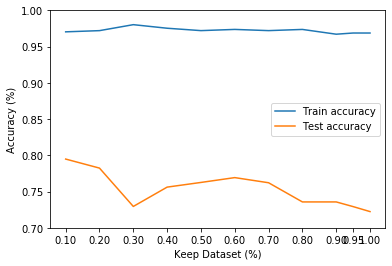

In [176]:
train_col = [col for col in history_qer.columns if col.startswith('Train')]
plt.plot(keep_data, history_qer.loc['Average', train_col], label='Train accuracy')
plt.plot(keep_data, history_qer.loc['Average', test_col], label='Test accuracy')
plt.legend()
plt.xlabel('Keep Dataset (%)')
plt.xticks(keep_data)
plt.ylabel('Accuracy (%)')
plt.ylim([.7, 1.0])

Refer from above result we can get the best result with we <b>keep 10% of dataset's features</b>, that is:

<h3>79.48%</h3>

### Multinomial Naive Bayes +  Query Expansion Ranking + TF-IDF

In [177]:
ngram = [(1, 1), (1, 2), (1, 3)]
min_df = [0.0, .1, .2, .3]
max_df = [.7 , .8, .9, 1.0]
keep_data = [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95, 1.]

param_combinations = list(product(ngram, min_df, max_df, keep_data))
param_combinations[:3]

[((1, 1), 0.0, 0.7, 0.1), ((1, 1), 0.0, 0.7, 0.2), ((1, 1), 0.0, 0.7, 0.3)]

In [178]:
NUM_BATCHES = 5
features = np.array(clean_comment)
labels = np.array(df.polarity)
train_eval, test_eval = [], []

for i in range(NUM_BATCHES):

    train_idx = np.load(f'dataset/train_{i+1}.npy')
    test_idx = np.load(f'dataset/test_{i+1}.npy')
    train_labels = labels[train_idx]
    test_labels = labels[test_idx]
    train_features = features[train_idx]

    # calculate qer score
    qer_score = calculate_qer_score(train_features, train_labels)
    size_train_features = len(qer_score)
    sorted_qer_score = sorted(qer_score.items(), key=lambda x: x[1])
    
    for param in param_combinations:
        # create new features with selected good feature with qer score
        boundary_idx = round(size_train_features * param[-1])
        below_tresh = [word[0] for word in sorted_qer_score[boundary_idx:]]
        new_features = remove_token(below_tresh, features)
        print(param)
        tfidf_vectorizer = TfidfVectorizer(ngram_range=param[0], min_df=param[1], max_df=param[2])
        new_train_features = tfidf_vectorizer.fit_transform(new_features[train_idx])
        new_test_features = tfidf_vectorizer.transform(new_features[test_idx])
        
        # train and evaluate
        clf = MultinomialNB()
        clf.fit(new_train_features, train_labels)
        train_acc = clf.score(new_train_features, train_labels)
        test_acc = clf.score(new_test_features, test_labels)
        
        train_eval.append(train_acc)
        test_eval.append(test_acc)

print('Train and evaluate model completed')

((1, 1), 0.0, 0.7, 0.1)
((1, 1), 0.0, 0.7, 0.2)
((1, 1), 0.0, 0.7, 0.3)
((1, 1), 0.0, 0.7, 0.4)
((1, 1), 0.0, 0.7, 0.5)
((1, 1), 0.0, 0.7, 0.6)
((1, 1), 0.0, 0.7, 0.7)
((1, 1), 0.0, 0.7, 0.8)
((1, 1), 0.0, 0.7, 0.9)
((1, 1), 0.0, 0.7, 0.95)
((1, 1), 0.0, 0.7, 1.0)
((1, 1), 0.0, 0.8, 0.1)
((1, 1), 0.0, 0.8, 0.2)
((1, 1), 0.0, 0.8, 0.3)
((1, 1), 0.0, 0.8, 0.4)
((1, 1), 0.0, 0.8, 0.5)
((1, 1), 0.0, 0.8, 0.6)
((1, 1), 0.0, 0.8, 0.7)
((1, 1), 0.0, 0.8, 0.8)
((1, 1), 0.0, 0.8, 0.9)
((1, 1), 0.0, 0.8, 0.95)
((1, 1), 0.0, 0.8, 1.0)
((1, 1), 0.0, 0.9, 0.1)
((1, 1), 0.0, 0.9, 0.2)
((1, 1), 0.0, 0.9, 0.3)
((1, 1), 0.0, 0.9, 0.4)
((1, 1), 0.0, 0.9, 0.5)
((1, 1), 0.0, 0.9, 0.6)
((1, 1), 0.0, 0.9, 0.7)
((1, 1), 0.0, 0.9, 0.8)
((1, 1), 0.0, 0.9, 0.9)
((1, 1), 0.0, 0.9, 0.95)
((1, 1), 0.0, 0.9, 1.0)
((1, 1), 0.0, 1.0, 0.1)
((1, 1), 0.0, 1.0, 0.2)
((1, 1), 0.0, 1.0, 0.3)
((1, 1), 0.0, 1.0, 0.4)
((1, 1), 0.0, 1.0, 0.5)
((1, 1), 0.0, 1.0, 0.6)
((1, 1), 0.0, 1.0, 0.7)
((1, 1), 0.0, 1.0, 0.8)
((1, 1), 0.0,

((1, 2), 0.3, 1.0, 0.3)
((1, 2), 0.3, 1.0, 0.4)
((1, 2), 0.3, 1.0, 0.5)
((1, 2), 0.3, 1.0, 0.6)
((1, 2), 0.3, 1.0, 0.7)
((1, 2), 0.3, 1.0, 0.8)
((1, 2), 0.3, 1.0, 0.9)
((1, 2), 0.3, 1.0, 0.95)
((1, 2), 0.3, 1.0, 1.0)
((1, 3), 0.0, 0.7, 0.1)
((1, 3), 0.0, 0.7, 0.2)
((1, 3), 0.0, 0.7, 0.3)
((1, 3), 0.0, 0.7, 0.4)
((1, 3), 0.0, 0.7, 0.5)
((1, 3), 0.0, 0.7, 0.6)
((1, 3), 0.0, 0.7, 0.7)
((1, 3), 0.0, 0.7, 0.8)
((1, 3), 0.0, 0.7, 0.9)
((1, 3), 0.0, 0.7, 0.95)
((1, 3), 0.0, 0.7, 1.0)
((1, 3), 0.0, 0.8, 0.1)
((1, 3), 0.0, 0.8, 0.2)
((1, 3), 0.0, 0.8, 0.3)
((1, 3), 0.0, 0.8, 0.4)
((1, 3), 0.0, 0.8, 0.5)
((1, 3), 0.0, 0.8, 0.6)
((1, 3), 0.0, 0.8, 0.7)
((1, 3), 0.0, 0.8, 0.8)
((1, 3), 0.0, 0.8, 0.9)
((1, 3), 0.0, 0.8, 0.95)
((1, 3), 0.0, 0.8, 1.0)
((1, 3), 0.0, 0.9, 0.1)
((1, 3), 0.0, 0.9, 0.2)
((1, 3), 0.0, 0.9, 0.3)
((1, 3), 0.0, 0.9, 0.4)
((1, 3), 0.0, 0.9, 0.5)
((1, 3), 0.0, 0.9, 0.6)
((1, 3), 0.0, 0.9, 0.7)
((1, 3), 0.0, 0.9, 0.8)
((1, 3), 0.0, 0.9, 0.9)
((1, 3), 0.0, 0.9, 0.95)
((1, 3), 0.0

((1, 1), 0.3, 0.9, 0.4)
((1, 1), 0.3, 0.9, 0.5)
((1, 1), 0.3, 0.9, 0.6)
((1, 1), 0.3, 0.9, 0.7)
((1, 1), 0.3, 0.9, 0.8)
((1, 1), 0.3, 0.9, 0.9)
((1, 1), 0.3, 0.9, 0.95)
((1, 1), 0.3, 0.9, 1.0)
((1, 1), 0.3, 1.0, 0.1)
((1, 1), 0.3, 1.0, 0.2)
((1, 1), 0.3, 1.0, 0.3)
((1, 1), 0.3, 1.0, 0.4)
((1, 1), 0.3, 1.0, 0.5)
((1, 1), 0.3, 1.0, 0.6)
((1, 1), 0.3, 1.0, 0.7)
((1, 1), 0.3, 1.0, 0.8)
((1, 1), 0.3, 1.0, 0.9)
((1, 1), 0.3, 1.0, 0.95)
((1, 1), 0.3, 1.0, 1.0)
((1, 2), 0.0, 0.7, 0.1)
((1, 2), 0.0, 0.7, 0.2)
((1, 2), 0.0, 0.7, 0.3)
((1, 2), 0.0, 0.7, 0.4)
((1, 2), 0.0, 0.7, 0.5)
((1, 2), 0.0, 0.7, 0.6)
((1, 2), 0.0, 0.7, 0.7)
((1, 2), 0.0, 0.7, 0.8)
((1, 2), 0.0, 0.7, 0.9)
((1, 2), 0.0, 0.7, 0.95)
((1, 2), 0.0, 0.7, 1.0)
((1, 2), 0.0, 0.8, 0.1)
((1, 2), 0.0, 0.8, 0.2)
((1, 2), 0.0, 0.8, 0.3)
((1, 2), 0.0, 0.8, 0.4)
((1, 2), 0.0, 0.8, 0.5)
((1, 2), 0.0, 0.8, 0.6)
((1, 2), 0.0, 0.8, 0.7)
((1, 2), 0.0, 0.8, 0.8)
((1, 2), 0.0, 0.8, 0.9)
((1, 2), 0.0, 0.8, 0.95)
((1, 2), 0.0, 0.8, 1.0)
((1, 2), 0.0

((1, 3), 0.3, 0.8, 0.4)
((1, 3), 0.3, 0.8, 0.5)
((1, 3), 0.3, 0.8, 0.6)
((1, 3), 0.3, 0.8, 0.7)
((1, 3), 0.3, 0.8, 0.8)
((1, 3), 0.3, 0.8, 0.9)
((1, 3), 0.3, 0.8, 0.95)
((1, 3), 0.3, 0.8, 1.0)
((1, 3), 0.3, 0.9, 0.1)
((1, 3), 0.3, 0.9, 0.2)
((1, 3), 0.3, 0.9, 0.3)
((1, 3), 0.3, 0.9, 0.4)
((1, 3), 0.3, 0.9, 0.5)
((1, 3), 0.3, 0.9, 0.6)
((1, 3), 0.3, 0.9, 0.7)
((1, 3), 0.3, 0.9, 0.8)
((1, 3), 0.3, 0.9, 0.9)
((1, 3), 0.3, 0.9, 0.95)
((1, 3), 0.3, 0.9, 1.0)
((1, 3), 0.3, 1.0, 0.1)
((1, 3), 0.3, 1.0, 0.2)
((1, 3), 0.3, 1.0, 0.3)
((1, 3), 0.3, 1.0, 0.4)
((1, 3), 0.3, 1.0, 0.5)
((1, 3), 0.3, 1.0, 0.6)
((1, 3), 0.3, 1.0, 0.7)
((1, 3), 0.3, 1.0, 0.8)
((1, 3), 0.3, 1.0, 0.9)
((1, 3), 0.3, 1.0, 0.95)
((1, 3), 0.3, 1.0, 1.0)
((1, 1), 0.0, 0.7, 0.1)
((1, 1), 0.0, 0.7, 0.2)
((1, 1), 0.0, 0.7, 0.3)
((1, 1), 0.0, 0.7, 0.4)
((1, 1), 0.0, 0.7, 0.5)
((1, 1), 0.0, 0.7, 0.6)
((1, 1), 0.0, 0.7, 0.7)
((1, 1), 0.0, 0.7, 0.8)
((1, 1), 0.0, 0.7, 0.9)
((1, 1), 0.0, 0.7, 0.95)
((1, 1), 0.0, 0.7, 1.0)
((1, 1), 0.0

((1, 2), 0.3, 0.8, 0.1)
((1, 2), 0.3, 0.8, 0.2)
((1, 2), 0.3, 0.8, 0.3)
((1, 2), 0.3, 0.8, 0.4)
((1, 2), 0.3, 0.8, 0.5)
((1, 2), 0.3, 0.8, 0.6)
((1, 2), 0.3, 0.8, 0.7)
((1, 2), 0.3, 0.8, 0.8)
((1, 2), 0.3, 0.8, 0.9)
((1, 2), 0.3, 0.8, 0.95)
((1, 2), 0.3, 0.8, 1.0)
((1, 2), 0.3, 0.9, 0.1)
((1, 2), 0.3, 0.9, 0.2)
((1, 2), 0.3, 0.9, 0.3)
((1, 2), 0.3, 0.9, 0.4)
((1, 2), 0.3, 0.9, 0.5)
((1, 2), 0.3, 0.9, 0.6)
((1, 2), 0.3, 0.9, 0.7)
((1, 2), 0.3, 0.9, 0.8)
((1, 2), 0.3, 0.9, 0.9)
((1, 2), 0.3, 0.9, 0.95)
((1, 2), 0.3, 0.9, 1.0)
((1, 2), 0.3, 1.0, 0.1)
((1, 2), 0.3, 1.0, 0.2)
((1, 2), 0.3, 1.0, 0.3)
((1, 2), 0.3, 1.0, 0.4)
((1, 2), 0.3, 1.0, 0.5)
((1, 2), 0.3, 1.0, 0.6)
((1, 2), 0.3, 1.0, 0.7)
((1, 2), 0.3, 1.0, 0.8)
((1, 2), 0.3, 1.0, 0.9)
((1, 2), 0.3, 1.0, 0.95)
((1, 2), 0.3, 1.0, 1.0)
((1, 3), 0.0, 0.7, 0.1)
((1, 3), 0.0, 0.7, 0.2)
((1, 3), 0.0, 0.7, 0.3)
((1, 3), 0.0, 0.7, 0.4)
((1, 3), 0.0, 0.7, 0.5)
((1, 3), 0.0, 0.7, 0.6)
((1, 3), 0.0, 0.7, 0.7)
((1, 3), 0.0, 0.7, 0.8)
((1, 3), 0.0,

((1, 1), 0.3, 0.7, 0.3)
((1, 1), 0.3, 0.7, 0.4)
((1, 1), 0.3, 0.7, 0.5)
((1, 1), 0.3, 0.7, 0.6)
((1, 1), 0.3, 0.7, 0.7)
((1, 1), 0.3, 0.7, 0.8)
((1, 1), 0.3, 0.7, 0.9)
((1, 1), 0.3, 0.7, 0.95)
((1, 1), 0.3, 0.7, 1.0)
((1, 1), 0.3, 0.8, 0.1)
((1, 1), 0.3, 0.8, 0.2)
((1, 1), 0.3, 0.8, 0.3)
((1, 1), 0.3, 0.8, 0.4)
((1, 1), 0.3, 0.8, 0.5)
((1, 1), 0.3, 0.8, 0.6)
((1, 1), 0.3, 0.8, 0.7)
((1, 1), 0.3, 0.8, 0.8)
((1, 1), 0.3, 0.8, 0.9)
((1, 1), 0.3, 0.8, 0.95)
((1, 1), 0.3, 0.8, 1.0)
((1, 1), 0.3, 0.9, 0.1)
((1, 1), 0.3, 0.9, 0.2)
((1, 1), 0.3, 0.9, 0.3)
((1, 1), 0.3, 0.9, 0.4)
((1, 1), 0.3, 0.9, 0.5)
((1, 1), 0.3, 0.9, 0.6)
((1, 1), 0.3, 0.9, 0.7)
((1, 1), 0.3, 0.9, 0.8)
((1, 1), 0.3, 0.9, 0.9)
((1, 1), 0.3, 0.9, 0.95)
((1, 1), 0.3, 0.9, 1.0)
((1, 1), 0.3, 1.0, 0.1)
((1, 1), 0.3, 1.0, 0.2)
((1, 1), 0.3, 1.0, 0.3)
((1, 1), 0.3, 1.0, 0.4)
((1, 1), 0.3, 1.0, 0.5)
((1, 1), 0.3, 1.0, 0.6)
((1, 1), 0.3, 1.0, 0.7)
((1, 1), 0.3, 1.0, 0.8)
((1, 1), 0.3, 1.0, 0.9)
((1, 1), 0.3, 1.0, 0.95)
((1, 1), 0.3

((1, 3), 0.2, 1.0, 0.4)
((1, 3), 0.2, 1.0, 0.5)
((1, 3), 0.2, 1.0, 0.6)
((1, 3), 0.2, 1.0, 0.7)
((1, 3), 0.2, 1.0, 0.8)
((1, 3), 0.2, 1.0, 0.9)
((1, 3), 0.2, 1.0, 0.95)
((1, 3), 0.2, 1.0, 1.0)
((1, 3), 0.3, 0.7, 0.1)
((1, 3), 0.3, 0.7, 0.2)
((1, 3), 0.3, 0.7, 0.3)
((1, 3), 0.3, 0.7, 0.4)
((1, 3), 0.3, 0.7, 0.5)
((1, 3), 0.3, 0.7, 0.6)
((1, 3), 0.3, 0.7, 0.7)
((1, 3), 0.3, 0.7, 0.8)
((1, 3), 0.3, 0.7, 0.9)
((1, 3), 0.3, 0.7, 0.95)
((1, 3), 0.3, 0.7, 1.0)
((1, 3), 0.3, 0.8, 0.1)
((1, 3), 0.3, 0.8, 0.2)
((1, 3), 0.3, 0.8, 0.3)
((1, 3), 0.3, 0.8, 0.4)
((1, 3), 0.3, 0.8, 0.5)
((1, 3), 0.3, 0.8, 0.6)
((1, 3), 0.3, 0.8, 0.7)
((1, 3), 0.3, 0.8, 0.8)
((1, 3), 0.3, 0.8, 0.9)
((1, 3), 0.3, 0.8, 0.95)
((1, 3), 0.3, 0.8, 1.0)
((1, 3), 0.3, 0.9, 0.1)
((1, 3), 0.3, 0.9, 0.2)
((1, 3), 0.3, 0.9, 0.3)
((1, 3), 0.3, 0.9, 0.4)
((1, 3), 0.3, 0.9, 0.5)
((1, 3), 0.3, 0.9, 0.6)
((1, 3), 0.3, 0.9, 0.7)
((1, 3), 0.3, 0.9, 0.8)
((1, 3), 0.3, 0.9, 0.9)
((1, 3), 0.3, 0.9, 0.95)
((1, 3), 0.3, 0.9, 1.0)
((1, 3), 0.3

((1, 2), 0.2, 0.9, 0.5)
((1, 2), 0.2, 0.9, 0.6)
((1, 2), 0.2, 0.9, 0.7)
((1, 2), 0.2, 0.9, 0.8)
((1, 2), 0.2, 0.9, 0.9)
((1, 2), 0.2, 0.9, 0.95)
((1, 2), 0.2, 0.9, 1.0)
((1, 2), 0.2, 1.0, 0.1)
((1, 2), 0.2, 1.0, 0.2)
((1, 2), 0.2, 1.0, 0.3)
((1, 2), 0.2, 1.0, 0.4)
((1, 2), 0.2, 1.0, 0.5)
((1, 2), 0.2, 1.0, 0.6)
((1, 2), 0.2, 1.0, 0.7)
((1, 2), 0.2, 1.0, 0.8)
((1, 2), 0.2, 1.0, 0.9)
((1, 2), 0.2, 1.0, 0.95)
((1, 2), 0.2, 1.0, 1.0)
((1, 2), 0.3, 0.7, 0.1)
((1, 2), 0.3, 0.7, 0.2)
((1, 2), 0.3, 0.7, 0.3)
((1, 2), 0.3, 0.7, 0.4)
((1, 2), 0.3, 0.7, 0.5)
((1, 2), 0.3, 0.7, 0.6)
((1, 2), 0.3, 0.7, 0.7)
((1, 2), 0.3, 0.7, 0.8)
((1, 2), 0.3, 0.7, 0.9)
((1, 2), 0.3, 0.7, 0.95)
((1, 2), 0.3, 0.7, 1.0)
((1, 2), 0.3, 0.8, 0.1)
((1, 2), 0.3, 0.8, 0.2)
((1, 2), 0.3, 0.8, 0.3)
((1, 2), 0.3, 0.8, 0.4)
((1, 2), 0.3, 0.8, 0.5)
((1, 2), 0.3, 0.8, 0.6)
((1, 2), 0.3, 0.8, 0.7)
((1, 2), 0.3, 0.8, 0.8)
((1, 2), 0.3, 0.8, 0.9)
((1, 2), 0.3, 0.8, 0.95)
((1, 2), 0.3, 0.8, 1.0)
((1, 2), 0.3, 0.9, 0.1)
((1, 2), 0.3

In [179]:
NUM_PARAMS = len(param_combinations)
train_history = [[] for i in range(NUM_PARAMS)]
test_history = [[] for i in range(NUM_PARAMS)]

for i in range(len(train_eval)):
    idx = i % NUM_PARAMS
    train_history[idx].append(train_eval[i])
    test_history[idx].append(test_eval[i])

# append the average accuracy
for i in range(NUM_PARAMS):
    train_history[i].append(sum(train_history[i])/NUM_BATCHES)
    test_history[i].append(sum(test_history[i])/NUM_BATCHES)

if len(train_history[-1]) == NUM_BATCHES+1:
    print('Done')

Done


In [182]:
eval_history = {}
for i in range(NUM_PARAMS):
    eval_history[f'Train Acc (ngram={param_combinations[i][0]}), min_df={param_combinations[i][1]}, max_df={param_combinations[i][2]}, keep data={param_combinations[i][-1]*100}%)'] = train_history[i] 
    eval_history[f'Test Acc (ngram={param_combinations[i][0]}), min_df={param_combinations[i][1]}, max_df={param_combinations[i][2]}, keep data={param_combinations[i][-1]*100}%)'] = test_history[i]
    , tresh={}
history_qer_tfidf = pd.DataFrame(eval_history, index=['Batch-1', 'Batch-2', 'Batch-3', 
                                                  'Batch-4', 'Batch-5', 'Average'])
history_qer_tfidf

,"Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, keep data=10.0%)","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, keep data=10.0%)","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, keep data=20.0%)","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, keep data=20.0%)","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, keep data=30.0%)","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, keep data=30.0%)","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, keep data=40.0%)","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, keep data=40.0%)","Train Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, keep data=50.0%)","Test Acc (ngram=(1, 1)), min_df=0.0, max_df=0.7, keep data=50.0%)",...,"Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, keep data=70.0%)","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, keep data=70.0%)","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, keep data=80.0%)","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, keep data=80.0%)","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, keep data=90.0%)","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, keep data=90.0%)","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, keep data=95.0%)","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, keep data=95.0%)","Train Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, keep data=100.0%)","Test Acc (ngram=(1, 3)), min_df=0.3, max_df=1.0, keep data=100.0%)"
Batch-1,0.966942,0.709677,0.983471,0.709677,0.991736,0.741935,0.983471,0.709677,0.983471,0.677419,...,0.553719,0.548387,0.553719,0.548387,0.842975,0.967742,0.842975,0.967742,0.834711,0.935484
Batch-2,0.966942,0.838710,0.975207,0.806452,0.975207,0.774194,0.975207,0.870968,0.975207,0.870968,...,0.553719,0.548387,0.801653,0.870968,0.826446,0.903226,0.826446,0.903226,0.826446,0.935484
Batch-3,0.983607,0.833333,0.983607,0.733333,0.983607,0.700000,0.975410,0.700000,0.975410,0.700000,...,0.557377,0.533333,0.557377,0.533333,0.860656,0.933333,0.860656,0.933333,0.860656,0.933333
Batch-4,0.967213,0.766667,0.967213,0.733333,0.967213,0.766667,0.967213,0.700000,0.967213,0.733333,...,0.549180,0.566667,0.549180,0.566667,0.868852,0.933333,0.868852,0.933333,0.868852,0.900000
Batch-5,0.983607,0.500000,0.983607,0.533333,0.991803,0.500000,0.983607,0.566667,0.983607,0.533333,...,0.549180,0.566667,0.549180,0.566667,0.934426,0.600000,0.934426,0.600000,0.868852,0.600000
Average,0.973662,0.729677,0.978621,0.703226,0.981913,0.696559,0.976981,0.709462,0.976981,0.703011,...,0.552635,0.552688,0.602222,0.617204,0.866671,0.867527,0.866671,0.867527,0.851904,0.860860


In [184]:
test_col = [col for col in history_qer_tfidf.columns if col.startswith('Test')]
test_col[history_qer_tfidf.loc['Average', test_col].argmax()]


'Test Acc (ngram=(1, 1)), min_df=0.2, max_df=0.7, keep data=40.0%)'

In [185]:
history_qer_tfidf[['Train Acc (ngram=(1, 1)), min_df=0.2, max_df=0.7, keep data=40.0%)', 'Test Acc (ngram=(1, 1)), min_df=0.2, max_df=0.7, keep data=40.0%)']]

,"Train Acc (ngram=(1, 1)), min_df=0.2, max_df=0.7, keep data=40.0%)","Test Acc (ngram=(1, 1)), min_df=0.2, max_df=0.7, keep data=40.0%)"
Batch-1,0.859504,0.935484
Batch-2,0.834711,1.000000
Batch-3,0.893443,0.933333
Batch-4,0.893443,0.933333
Batch-5,0.967213,0.633333
Average,0.889663,0.887097


We got <b>the best result</b> from Multinomial Naive Bayes Model with <b>Query Expansion Ranking</b> 
as feature selection with we <b>keep 40% of dataset's features</b>,
and another parameter from TF-IDF such as <b>minimum</b> of word's occurrences is <b>20%</b> of total documents, 
<b>maximum</b> of word's occurrences is <b>70%</b> of total documents, 
<b>only use 1 gram</b> that is: <h3>88.71%</h3>

In [228]:
models = ['MNB', 'MNB + TF-IDF', 'MNB + IG', 'MNB + IG + TF-IDF',
             'MNB + CHI2', 'MNB + CHI2 + TF-IDF', 'MNB + QER',
             'MNB + QER + TF-IDF']
test_accuracy_avg = [72.24, 86.01, 89.03, 86.01, 78.15, 87.40, 79.48, 88.71]

res_df = pd.DataFrame({'Model + Feature Selection': models, 'Test Accuracy': test_accuracy_avg})
res_df

,Model + Feature Selection,Test Accuracy
0,MNB,72.24
1,MNB + TF-IDF,86.01
2,MNB + IG,89.03
3,MNB + IG + TF-IDF,86.01
4,MNB + CHI2,78.15
5,MNB + CHI2 + TF-IDF,87.40
6,MNB + QER,79.48
7,MNB + QER + TF-IDF,88.71


Text(0, 0.5, 'Classification Model + Feature Selection')

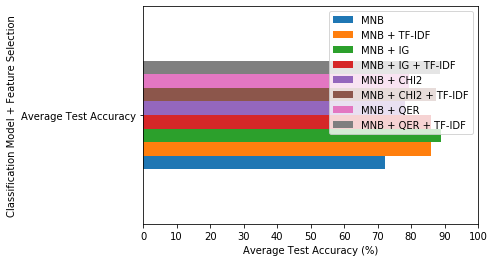

In [219]:
res_df.plot.barh()
plt.xticks([i*10 for i in range(11)])
plt.xlabel('Average Test Accuracy (%)')
plt.ylabel('Classification Model + Feature Selection')


(65, 90)

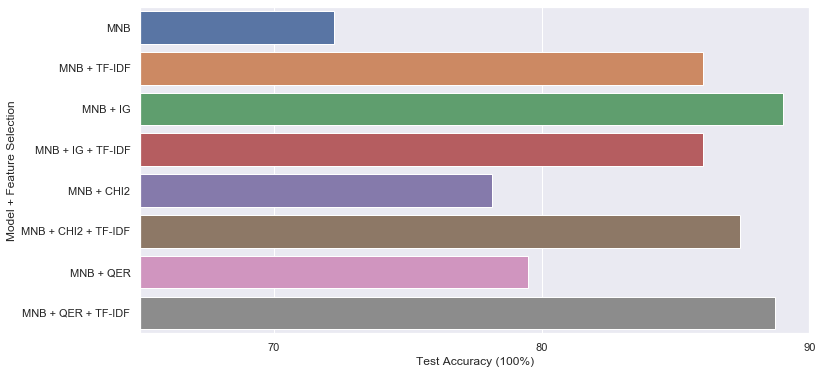

In [243]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12, 6)})

ax = sns.barplot(x='Test Accuracy', y='Model + Feature Selection', data=res_df)
ax.set_xlabel('Test Accuracy (100%)')
plt.xticks([i*10 for i in range(11)])
plt.xlim([65, 90])